# Sankey Diagram of Data in Data Commons

The purpose of this notebook is to provide a visual representation of the availability and connectivity of some of the data in the Data Commons.  The Data are:
* EPA_GHGRP: Asset-level data (physical plants and operations in the US that emit >= 25 kt CO2e and others covered by GHG Reporting Project)
* GLEIF: Legal Entity Identifiers for parent companies that own assets (and identification of parent companies that don't have LEIs)
* Type of emissions from parent companies: Direct Emitters, LDC Emissions, On-Shore Refining, Gathering and Boosting, Transmission Pipelines, SF6 from Electrical Equipment
* Types of operations by SIC/NAICS codes (Steel, Cement, Electricity Generation, Pulp and Paper Manufacturing, etc)
* Sectors (Manufacturing, Transportation Communications and Utilities, Service Industries, Mining, etc)
* SEC 10-K reports: Revenue Data (can be compared/contrasted with EPA CO2e emissions data)

The data developed in this notebook comes from https://github.com/os-climate/data-platform-demo/blob/iceberg/notebooks/EPA_GHGRP-demos.ipynb  
and can be visualized by SuperSet here: https://superset-secure-odh-superset.apps.odh-cl2.apps.os-climate.org/

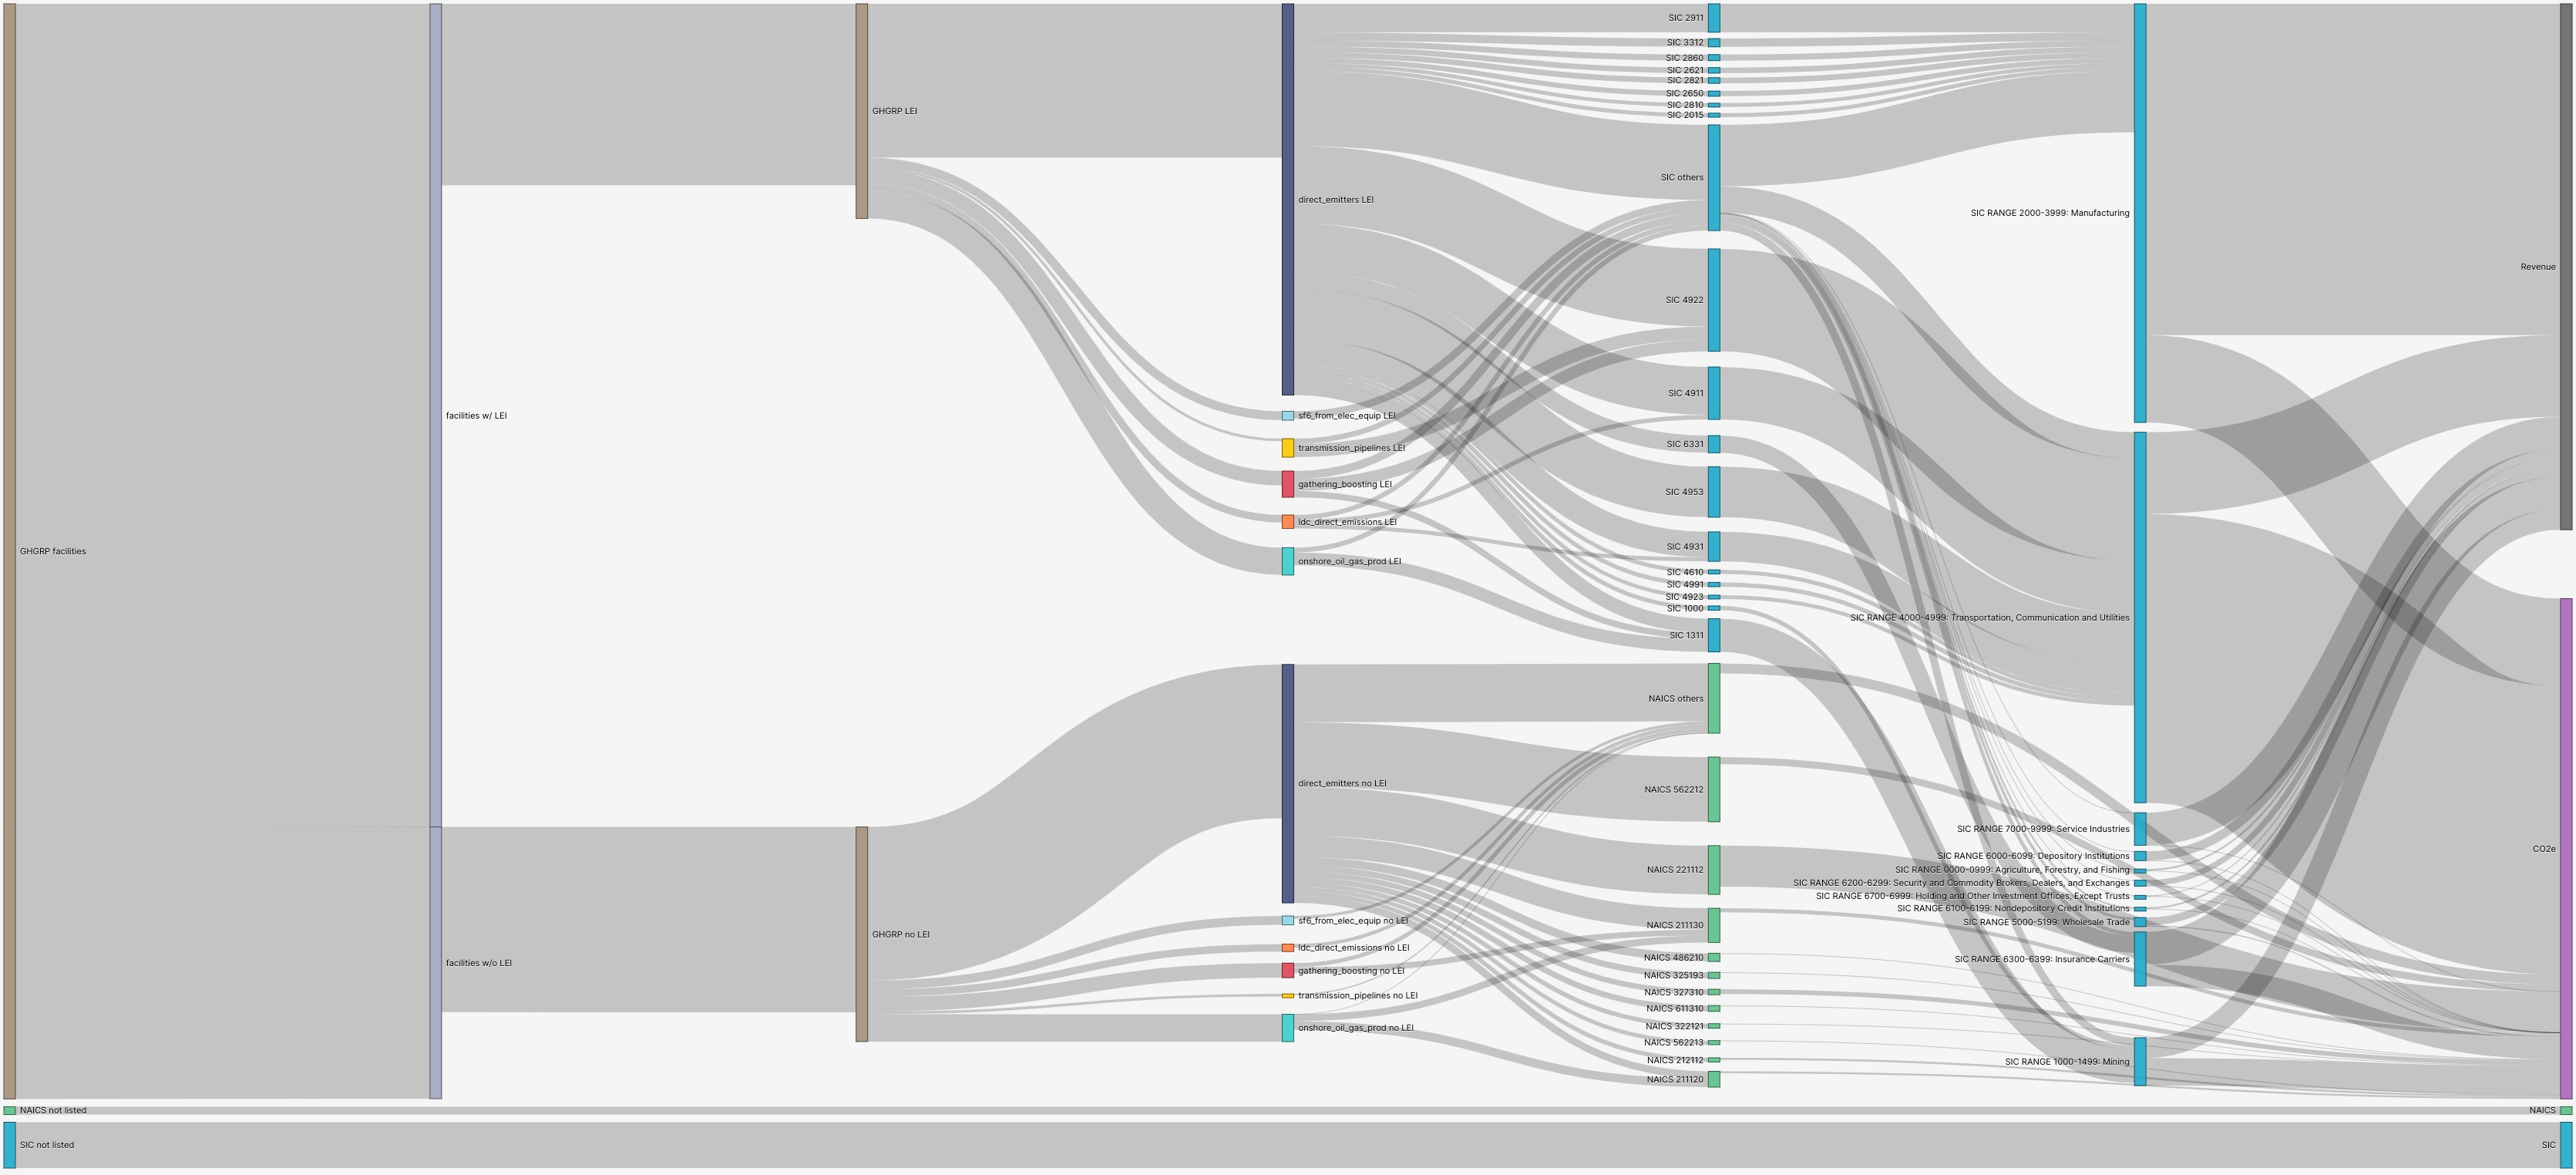

This data is incomplete from a number of perspectives:
* Major non-emitting power plants (hydro electric dams, solar arrays, wind turbines, and nuclear powerplants) may be missing as assets
* There are no metrics for energy generation or consumption, nor for other units of production (such as tons of steel produced)
* All emissions are essentially Scope 1 emissions; there are no Scope 2 attributions for major energy consumers (such as Steel manufacturing)
* There are also no Scope 3 metrics
* The data is exclusively US-based

Despite these shortcomings, this illustration/demonstration shows how additional data can be linked in to provide a more complete picture:
* WRI Power Plant data, providing a global perspective on power plants, including emissions, generation, capacity, fuel type, etc.
* RMI Utility Transition Hub data, providing fine-grained, up-to-date information about US power plants, including emissions targets
* SEC data at Business Segment level (to separate Berkshire Hathaway's $65B energy business from their overall $265B enterprise, for example)
* SPGI sustainability reports (require NLP analysis to yield quantitative metrics)
* etc.

### Begin with Credentials and Connection to Trino

In [1]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

Set session variable CATALOG to make query terms much more compact

In [2]:
import trino
from sqlalchemy.engine import create_engine

env_var_prefix = 'TRINO'

sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ[f'{env_var_prefix}_USER'],
    host = os.environ[f'{env_var_prefix}_HOST'],
    port = os.environ[f'{env_var_prefix}_PORT']
)

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'sandbox'
census_table_prefix = 'census_'
dera_table_prefix = 'dera_'
epa_table_prefix = 'epa_'

sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ[f'{env_var_prefix}_PASSWD']),
    'http_scheme': 'https',
    'catalog': ingest_catalog,
    'schema': ingest_schema,
}
engine = create_engine(sqlstring, connect_args = sqlargs)
connection = engine.connect()

import pandas as pd

import osc_ingest_trino as osc

Leftmost in the diagram are the facilities.  Some facilities are owned by entities with known LEIs, others are not.

In [3]:
fac_lei_list = engine.execute(f"""
select count (*), lei from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
where PA.lei is not null and PA.reporting_year=DATE('2020-01-01')
group by lei
order by count (*) desc""").fetchall()

fac_nolei_list = engine.execute(f"""
select count (*), parent_company_name from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
where PA.lei is null and PA.reporting_year=DATE('2020-01-01')
group by parent_company_name
order by count (*) desc""").fetchall()

Companies reporting to the SEC DERA database list their primary SIC code.  `SIC_NOLIST_LEI_LIST` contains a list of SIC codes reported to SEC DERA that are not otherwise listed in the EPA GHGRP data.

In [4]:
sic_nolist_lei_list = engine.execute(f"""
select count (*), S.sic
from {dera_table_prefix}sub as S inner join
  (select S2.lei as lei
   from {dera_table_prefix}sub as S2
   where S2.fp='FY' and S2.fy=DATE('2020-01-01') and (S2.form='10-K' or S2.form='20-F' or S2.form='40-F')
   except
   select distinct(PA.lei) from {ingest_schema}.{epa_table_prefix}parent_attribution as PA where PA.lei IS NOT NULL and reporting_year=DATE('2020-01-01')) as S2_lei 
on S.lei=S2_lei.lei
where S.fp='FY' and S.fy=DATE('2020-01-01') and (S.form='10-K' or S.form='20-F' or S.form='40-F')
group by S.sic
order by count (*) desc
""").fetchall()

Facilities in the EPA GHGRP dataset are categorized by a NAICS (not SIC) code.  `naics_nolist_nolei_list` contains the list of NAICS codes that will not be overriden by the SIC code of a publicly reporting company.

In [5]:
naics_nolist_nolei_list = engine.execute(f"""
select count (*), fnc
from (select PA.facility_naics_code as fnc
      from {epa_table_prefix}parent_company as PA
      where PA.reporting_year=DATE('2020-01-01') and PA.lei IS NULL
      except
      select distinct(PA2.facility_naics_code) as fnc
      from {ingest_schema}.{epa_table_prefix}parent_attribution as PA2 inner join {dera_table_prefix}sub as S
      on PA2.lei=S.lei and PA2.reporting_year=S.fy
      where PA2.reporting_year=DATE('2020-01-01') and (S.form='10-K' or S.form='20-F' or S.form='40-F') and S.fp='FY')
group by fnc
order by count (*) desc
""").fetchall()

The initial left-hand side of the Sankey diagram:

In [6]:
sankey_data = [
    ['SIC not listed', 'SIC', len(sic_nolist_lei_list)],
    ['GHGRP facilities', 'facilities w/ LEI', sum([x[0] for x in fac_lei_list])],
    ['facilities w/ LEI', 'GHGRP LEI', len(fac_lei_list)],
    ['GHGRP facilities', 'facilities w/o LEI', sum([x[0] for x in fac_nolei_list])],
    ['facilities w/o LEI', 'GHGRP no LEI', len(fac_nolei_list)],
    ['NAICS not listed', 'NAICS', len(naics_nolist_nolei_list)],
]
display(sankey_data)

[['SIC not listed', 'SIC', 369],
 ['GHGRP facilities', 'facilities w/ LEI', 6503],
 ['facilities w/ LEI', 'GHGRP LEI', 1433],
 ['GHGRP facilities', 'facilities w/o LEI', 2147],
 ['facilities w/o LEI', 'GHGRP no LEI', 1464],
 ['NAICS not listed', 'NAICS', 62]]

In [7]:
engine.execute(f"select distinct(table_source) from {ingest_schema}.{epa_table_prefix}parent_attribution where reporting_year=DATE('2020-01-01')").fetchall()

# Note here that PARENT_ATTRIBUTION doesn't yet have source data from SUPPLIERS, CO2_INJECTION, nor GEOLOGIC_SEQUESTRATION_OF_CO2

[('sf6_from_elec_equip',),
 ('onshore_oil_gas_prod',),
 ('gathering_boosting',),
 ('ldc_direct_emissions',),
 ('transmission_pipelines',),
 ('direct_emitters',)]

Build the next stages of the Sankey Diagram:
* Facilities (LEI and no LEI) -> Parent Companies (LEI and no LEI)
* Parent Companies -> Emitter Categories (Direct Emitters, etc)
* Emitter Categories -> SIC/NAICS codes
* SIC/NAICS codes -> grouped SIC/NAICS codes

In [8]:
sic_others_cutoff = 30
naics_others_cutoff = 31

sic_df = pd.read_sql(f"select * from {census_table_prefix}sic_ranges", engine)

def get_range_string(df):
    return sic_df[(df.l <= sic) & (df.r >= sic)][['range', 'range_desc']].agg(': '.join, axis=1).squeeze()

for tname in ['direct_emitters', 'onshore_oil_gas_prod', 'gathering_boosting',
             'transmission_pipelines', 'ldc_direct_emissions', 'sf6_from_elec_equip',
             # 'suppliers', 'co2_injection', 'geologic_sequestration_of_co2'
             ]:
    lei_2_epa_class_cnt = engine.execute(f"""
select count (*) from
  (select distinct(lei) from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
   where PA.lei IS NOT NULL and table_source='{tname}' and reporting_year=DATE('2020-01-01'))
""").fetchall()[0][0]
    sankey_data.append(['GHGRP LEI', f'{tname} LEI', lei_2_epa_class_cnt])
    epa_lei_class_2_sic_list = engine.execute(f"""
select count (*), sic
from {ingest_schema}.{epa_table_prefix}parent_attribution as PA join {dera_table_prefix}sub as S
on PA.lei=S.lei and PA.reporting_year=S.fy
where PA.reporting_year=DATE('2020-01-01') and S.fp='FY' and (S.form='10-K' or S.form='20-F' or S.form='40-F') and table_source='{tname}'
group by sic
order by count (*) desc
""").fetchall()
    for row in epa_lei_class_2_sic_list:
        if row[0]==0:
            continue
        sic = row[1]
        range_string = get_range_string(sic_df)
        if row[0] < sic_others_cutoff:
            sankey_data.append([f"SIC others", f"SIC RANGE {range_string}", row[0]])
            continue
        sankey_data.append([f'{tname} LEI', f"SIC {sic}", row[0]])
        sankey_data.append([f"SIC {sic}", f"SIC RANGE {range_string}", row[0]])
    sankey_data.append([f'{tname} LEI', f"SIC others", sum([x[0] for x in epa_lei_class_2_sic_list if x[0] < sic_others_cutoff])])
    
    nolei_2_epa_class_cnt = engine.execute(f"""
select count (*) from
  (select distinct(parent_company_name) from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
   where PA.lei IS NULL and table_source='{tname}' and reporting_year=DATE('2020-01-01'))
""").fetchall()[0][0]
    sankey_data.append(['GHGRP no LEI', f'{tname} no LEI', lei_2_epa_class_cnt])
    epa_nolei_class_2_naics_list = engine.execute(f"""
select count (*), facility_naics_code
from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
where PA.reporting_year=DATE('2020-01-01') and PA.lei IS NULL and table_source='{tname}'
group by facility_naics_code
order by count (*) desc
""").fetchall()
    for row in epa_nolei_class_2_naics_list:
        if row[0] < naics_others_cutoff:
            continue
        naics = row[1]
        sankey_data.append([f'{tname} no LEI', f"NAICS {naics}", row[0]])
    sankey_data.append([f'{tname} no LEI', f"NAICS others", sum([x[0] for x in epa_nolei_class_2_naics_list if x[0] < naics_others_cutoff])])

Build the right-hand side of the diagram: SIC groups to Revenues and CO2e (arbitrarily scaled)

In [9]:
revenue_scale_factor = 1e3
co2e_scale_factor = 7e5

qres = engine.execute(f"""
select PA.lei, sic, sum(fractional_emissions) as tot_co2e, round(max(value)/1000000,3) as tot_revenue
from {ingest_schema}.{epa_table_prefix}parent_attribution as PA join {dera_table_prefix}sub as S on PA.lei=S.lei and PA.reporting_year=S.fy
     join {dera_table_prefix}num as N on S.adsh=N.adsh
where PA.reporting_year=DATE('2020-01-01')
and S.fp='FY' and (S.form='10-K' or S.form='20-F' or S.form='40-F')
and ddate>=DATE('2020-01-01') and ddate<DATE('2021-01-01')
and coreg is NULL
and (N.tag='Revenues'
     or N.tag='RevenueFromContractWithCustomerIncludingAssessedTax'
     or N.tag='RevenueFromContractWithCustomerExcludingAssessedTax'
     or N.tag='RevenuesNetOfInterestExpense'
     or N.tag='RegulatedAndUnregulatedOperatingRevenue'
     or N.tag='RegulatedOperatingRevenuePipelines')
and N.qtrs=4
group by PA.lei, sic
""").fetchall()

for row in qres:
    sic = row[1]
    co2e = row[2]/co2e_scale_factor
    rev = row[3]/revenue_scale_factor
    range_string = get_range_string(sic_df)
    sankey_data.append([f"SIC RANGE {range_string}", "CO2e", co2e])
    sankey_data.append([f"SIC RANGE {range_string}", "Revenue", rev])

Build the right-hand side of the diagram: NAICS codes to CO2e (arbitrarily scaled).  We don't have revenue information for these emissions.

In [10]:
qres = engine.execute(f"""
select count (*), PA.facility_naics_code, sum(PA.fractional_emissions) as tot_co2e
from {ingest_schema}.{epa_table_prefix}parent_attribution as PA
where PA.lei IS NULL and PA.reporting_year=DATE('2020-01-01')
group by PA.facility_naics_code
""").fetchall()

for row in qres:
    cnt = row[0]
    naics = row[1]
    co2e = row[2]/co2e_scale_factor
    if cnt < naics_others_cutoff:
        sankey_data.append([f"NAICS others", "CO2e", co2e])
    else:
        sankey_data.append([f"NAICS {naics}", "CO2e", co2e])

In [11]:
df = pd.DataFrame(data=sankey_data, columns=('source', 'target', 'qty'))

df['year'] = pd.to_datetime("2020-01-01")
df = df.convert_dtypes()

In [12]:
def create_sankey_table(tablename, df, partitioning=''):
    ingest_table = f'{epa_table_prefix}{tablename}'
    columnschema = osc.create_table_schema_pairs(df, typemap={"datetime64[ns]":"timestamp(6)",
                                                              "datetime64[ns, UTC]":"timestamp(6) with time zone"})

    drop_table = engine.execute(f"drop table if exists {ingest_schema}.{ingest_table}")
    drop_table.fetchall()

    tabledef = f"""
create table if not exists {ingest_catalog}.{ingest_schema}.{ingest_table}(
{columnschema}
) with (
{'partitioning = ' if partitioning else ''}{partitioning}{',' if partitioning else ''}
format = 'ORC'
)
"""
    print(tabledef)
    qres = engine.execute(tabledef)
    print(qres.fetchall())
    df.to_sql(ingest_table,
              con=engine, schema=ingest_schema, if_exists='append',
              index=False,
              method=osc.TrinoBatchInsert(batch_size = 10000, verbose = True))

In [13]:
create_sankey_table("sankey", df)

qres = engine.execute(f"select * from {ingest_schema}.{epa_table_prefix}sankey")
# qres.fetchall()


create table if not exists osc_datacommons_dev.sandbox.epa_sankey(
    source varchar,
    target varchar,
    qty double,
    year timestamp(6)
) with (

format = 'ORC'
)

[(True,)]
constructed fully qualified table name as: "sandbox.epa_sankey"
inserting 1022 records
  ('SIC not listed', 'SIC', 369.0, TIMESTAMP '2020-01-01 00:00:00')
  ('GHGRP facilities', 'facilities w/ LEI', 6503.0, TIMESTAMP '2020-01-01 00:00:00')
  ('facilities w/ LEI', 'GHGRP LEI', 1433.0, TIMESTAMP '2020-01-01 00:00:00')
  ...
  ('NAICS others', 'CO2e', 0.018401645714285715, TIMESTAMP '2020-01-01 00:00:00')
batch insert result: [(1022,)]
